In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from seaborn import heatmap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define terms related to goods
good_terms = ['bead', 'carpet', 'cloth', 'iron', 'knives', 'rum', 'gold', 'wine', 'sugar', 'oil', 'peas', 'tallow', 'tobacco', 'slave']

In [8]:
# Load data
df = pd.read_csv('csv/metadata_text_merged.csv')
texts = df['text'].tolist()

In [34]:
# Create dictionary of dictionaries corresponding to pairs of items
item_pair_counts = {}

for good_name in good_terms:
    item_pair_counts[good_name] = {}
    
for key in item_pair_counts.keys():
    for good_name in good_terms:
        item_pair_counts[key][good_name] = 0

In [35]:
# Iterate over texts and fill in matrix
for text in tqdm_notebook(texts):
    # Boolean dict of dicts for explored pairs
    explored = {}
    
    for good_name in good_terms:
        explored[good_name] = {}
    
    for key in explored.keys():
        for good_name in good_terms:
            explored[key][good_name] = False
    
    
    for good1 in good_terms:
        for good2 in good_terms:
            if good1 != good2:
                if explored[good1][good2] is False and explored[good2][good1] is False and good1 in text and good2 in text:
                    # Update counts
                    item_pair_counts[good1][good2] += 1
                    item_pair_counts[good2][good1] += 1
                    
                    # Mark as explored
                    explored[good1][good2] = True
                    explored[good2][good1] = True

A Jupyter Widget

In [36]:
count_matrix = pd.DataFrame(item_pair_counts)

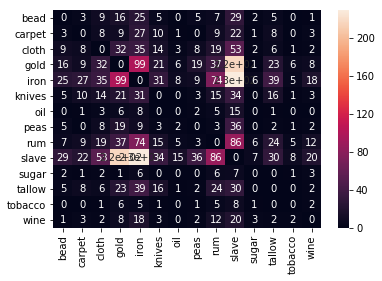

In [37]:
heatmap(count_matrix, annot=True)